# 1. Predicting Heart Disease Using a Classification Tree

## 1.1 Data Cleaning

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import category_encoders as ce
import matplotlib.pyplot as plt
import seaborn as sns
from econml.grf import CausalForest
from sklearn.linear_model import LinearRegression

In [5]:
# --- Leer datos ---
data = pd.read_csv("C:/Users/VICTOR/Documents/GitHub/Decision_Trees/R/input/processed.cleveland.data",
                   header=None)

# --- Renombrar columnas ---
data.columns = ['age', 'sex', 'cp', 'restbp', 'chol', 'fbs',
                'restecg', 'thalach', 'exang', 'oldpeak',
                'slope', 'ca', 'thal', 'hd']

# --- Reemplazar "?" por NaN y eliminar ---
data = data.replace("?", np.nan).dropna()
data = data.apply(pd.to_numeric)

# --- Crear variable binaria de enfermedad ---
data['y'] = np.where(data['hd'] > 0, 1, 0)

# --- Variables categóricas ---
categorical_vars = ["cp", "restecg", "slope", "ca", "thal", "hd"]
for var in categorical_vars:
    data[var] = data[var].astype('category')

# --- Crear variables dummy ---
encoder = ce.OneHotEncoder(cols=categorical_vars, drop_invariant=True, use_cat_names=True)
data = encoder.fit_transform(data)


## 1.2 Data Analysis

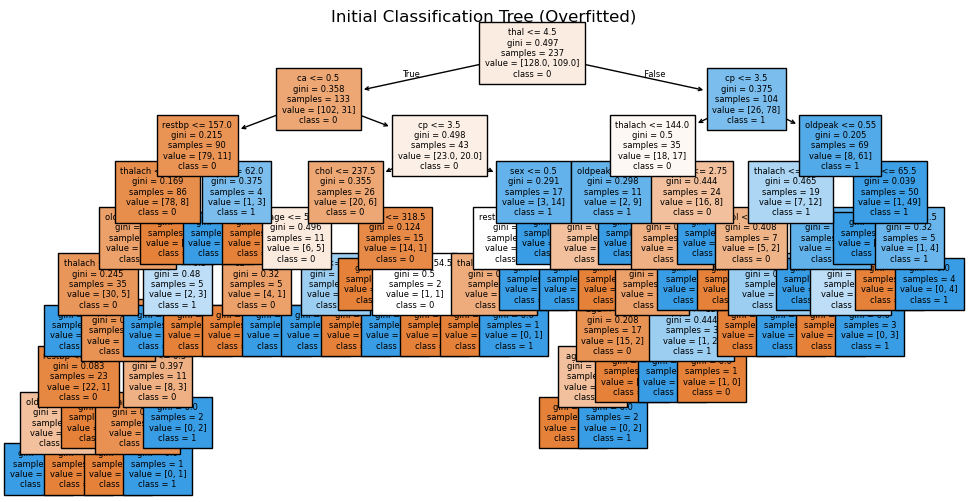

Initial accuracy: 0.85
[[28  4]
 [ 5 23]]
              precision    recall  f1-score   support

           0       0.85      0.88      0.86        32
           1       0.85      0.82      0.84        28

    accuracy                           0.85        60
   macro avg       0.85      0.85      0.85        60
weighted avg       0.85      0.85      0.85        60



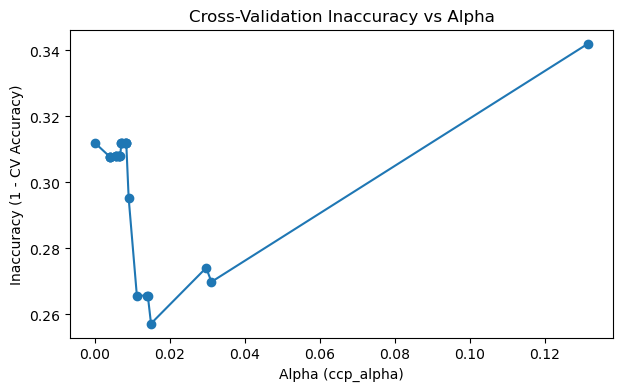

Optimal alpha (cp): 0.014963376988693433


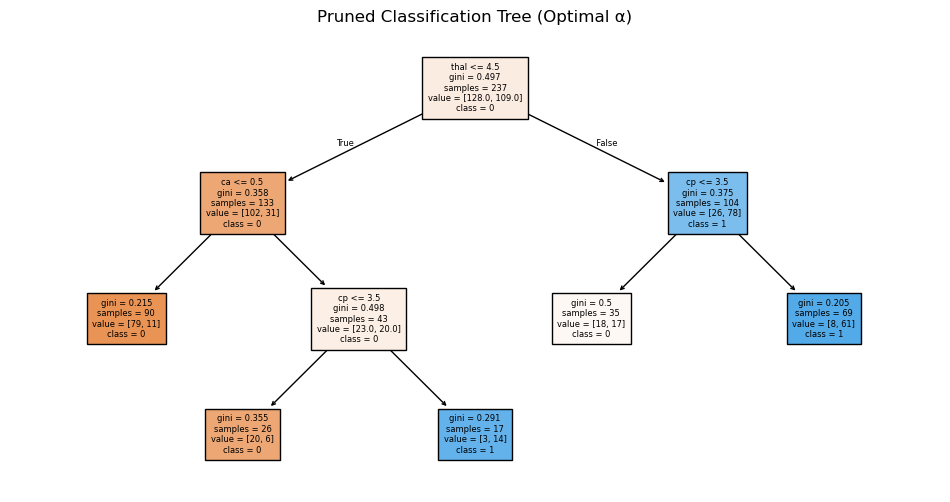

Accuracy after pruning: 0.85
[[30  2]
 [ 7 21]]
              precision    recall  f1-score   support

           0       0.81      0.94      0.87        32
           1       0.91      0.75      0.82        28

    accuracy                           0.85        60
   macro avg       0.86      0.84      0.85        60
weighted avg       0.86      0.85      0.85        60



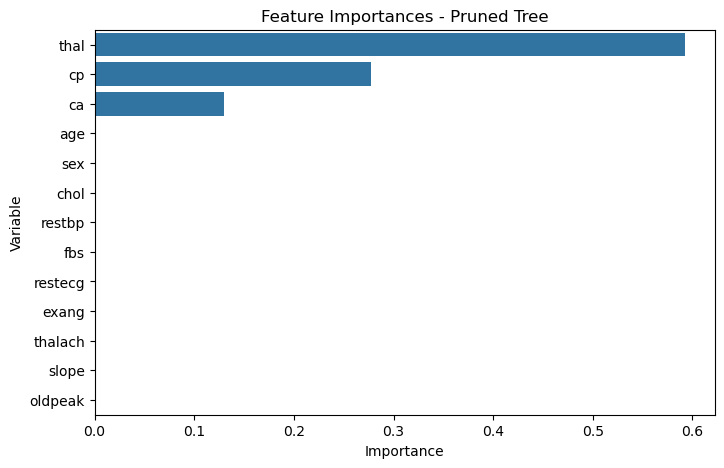

In [7]:
# --- PARTE 1.2: Árbol de Decisión con Pruning y Feature Importance ---

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# 1️⃣ Cargar datos
data = pd.read_csv("C:/Users/VICTOR/Documents/GitHub/Decision_Trees/R/input/processed.cleveland.data",
                   header=None)
data.columns = ['age', 'sex', 'cp', 'restbp', 'chol', 'fbs',
                'restecg', 'thalach', 'exang', 'oldpeak',
                'slope', 'ca', 'thal', 'hd']

# 2️⃣ Limpiar datos ("?" → NaN, eliminar NA)
data.replace('?', np.nan, inplace=True)
data.dropna(inplace=True)
data = data.apply(pd.to_numeric)

# 3️⃣ Variable binaria de resultado
data['y'] = np.where(data['hd'] > 0, 1, 0)

# 4️⃣ Convertir categóricas
categorical = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
for col in categorical:
    data[col] = data[col].astype('category')

# 5️⃣ Dividir en train/test
X = data.drop(columns=['hd', 'y'])
y = data['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123)

# 6️⃣ Árbol inicial (sin pruning)
tree_model = DecisionTreeClassifier(random_state=123)
tree_model.fit(X_train, y_train)

# Graficar árbol
plt.figure(figsize=(12,6))
plot_tree(tree_model, filled=True, feature_names=X.columns, class_names=['0','1'], fontsize=6)
plt.title("Initial Classification Tree (Overfitted)")
plt.show()

# 7️⃣ Matriz de confusión inicial
y_pred = tree_model.predict(X_test)
print("Initial accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# 8️⃣ Cross-validation para pruning
path = tree_model.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas

cv_scores = []
for alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=123, ccp_alpha=alpha)
    scores = cross_val_score(clf, X_train, y_train, cv=4)
    cv_scores.append(scores.mean())

# Graficar curva de inaccuracy
plt.figure(figsize=(7,4))
plt.plot(ccp_alphas, [1 - s for s in cv_scores], marker='o')
plt.xlabel("Alpha (ccp_alpha)")
plt.ylabel("Inaccuracy (1 - CV Accuracy)")
plt.title("Cross-Validation Inaccuracy vs Alpha")
plt.show()

best_alpha = ccp_alphas[np.argmax(cv_scores)]
print("Optimal alpha (cp):", best_alpha)

# 9️⃣ Árbol podado
pruned_tree = DecisionTreeClassifier(random_state=123, ccp_alpha=best_alpha)
pruned_tree.fit(X_train, y_train)

plt.figure(figsize=(12,6))
plot_tree(pruned_tree, filled=True, feature_names=X.columns, class_names=['0','1'], fontsize=6)
plt.title("Pruned Classification Tree (Optimal α)")
plt.show()

# 🔟 Evaluación final
y_pred_pruned = pruned_tree.predict(X_test)
print("Accuracy after pruning:", accuracy_score(y_test, y_pred_pruned))
print(confusion_matrix(y_test, y_pred_pruned))
print(classification_report(y_test, y_pred_pruned))

# 1️⃣1️⃣ Importancia de variables
importances = pd.Series(pruned_tree.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(8,5))
sns.barplot(x=importances, y=importances.index)
plt.title("Feature Importances - Pruned Tree")
plt.xlabel("Importance")
plt.ylabel("Variable")
plt.show()


# 2. Causal Forest 

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                 1.045e+04
Date:                Sun, 02 Nov 2025   Prob (F-statistic):          2.26e-232
Time:                        17:40:07   Log-Likelihood:                -699.22
No. Observations:                 297   AIC:                             1402.
Df Residuals:                     295   BIC:                             1410.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0637      0.211     -0.302      0.7

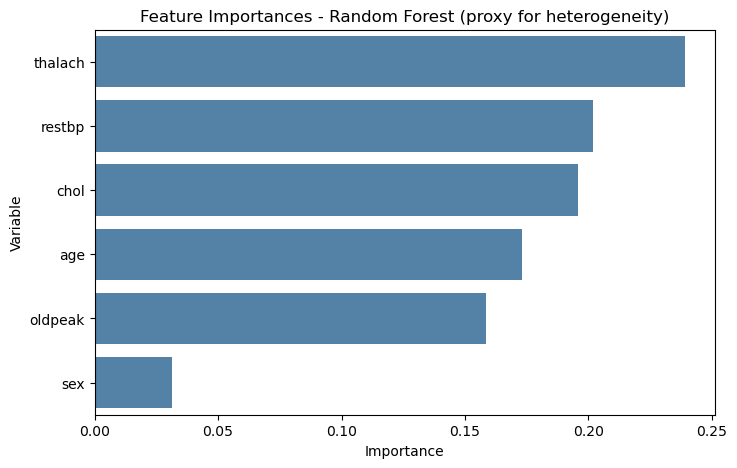

In [8]:
# --- PARTE 2: Causal Forest simplificado (simulación + análisis heterogeneidad) ---

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore

np.random.seed(123)

# 1️⃣ Leer y limpiar (igual que antes)
data = pd.read_csv("C:/Users/VICTOR/Documents/GitHub/Decision_Trees/R/input/processed.cleveland.data", header=None)
data.columns = ['age', 'sex', 'cp', 'restbp', 'chol', 'fbs', 'restecg',
                'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'hd']
data.replace('?', np.nan, inplace=True)
data.dropna(inplace=True)
data = data.apply(pd.to_numeric)

# 2️⃣ Simular tratamiento y outcome
n = data.shape[0]
data['T'] = np.random.binomial(1, 0.5, n)
eps = np.random.normal(0, 1, n)
data['Y'] = (1 + 0.05*data['age'] + 0.3*data['sex'] + 0.2*data['restbp'])*data['T'] + 0.5*data['oldpeak']*eps

# 3️⃣ Estimar efecto promedio con OLS
import statsmodels.api as sm
ols = sm.OLS(data['Y'], sm.add_constant(data['T'])).fit()
print(ols.summary())

# 4️⃣ Feature importance (proxy: modelo de bosque aleatorio)
X = data[['age', 'sex', 'restbp', 'chol', 'thalach', 'oldpeak']]
rf = RandomForestRegressor(random_state=123)
rf.fit(X, data['Y'])
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

# Visualizar importancia
plt.figure(figsize=(8,5))
sns.barplot(x=importances, y=importances.index, color='steelblue')
plt.title("Feature Importances - Random Forest (proxy for heterogeneity)")
plt.xlabel("Importance")
plt.ylabel("Variable")
plt.show()

# 5️⃣ Efectos simulados
